In [15]:
import os
import zipfile
from google.colab import drive

drive.mount('/content/drive')

DRIVE_PROJECT_PATH = '/content/drive/MyDrive/skin_lession_classification'
ZIP_PATH = os.path.join(DRIVE_PROJECT_PATH, 'dataset.zip')

if not os.path.exists('/content/dataset'):
    print("Veri seti açılıyor")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
    print("BAŞARILI! Veri seti '/content/dataset' klasörüne açıldı.")
else:
    print("Veri seti zaten hazır.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Veri seti zaten hazır.


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Eğitim şu cihazda yapılacak: {device}")

DATA_DIR = '/content/dataset'
CLASSES = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print(f"Sınıflar: {CLASSES}")

Eğitim şu cihazda yapılacak: cuda:0
Sınıflar: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [17]:
print("--- 1. Deep Learning (ResNet50) Ablasyon Çalışması Başlıyor ---")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 1.a Ablasyon Çalışması (Weighted Loss)
# sinif sayilarini hesapliyoruz
class_counts = []
for x in ['train']:
    targets = image_datasets[x].targets
    counts = np.bincount(targets)
    class_counts = counts

# Ağırlık hesabı: (Toplam Örnek / (Sınıf Sayısı * Sınıf Frekansı))
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

print(f"Hesaplanan Sınıf Ağırlıkları: {class_weights}")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(CLASSES))
model = model.to(device)

# 1.a Ablasyon loss fonksiyonu olarak weighted loss kullaniyoruz
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Baseline: optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 1.b Ablasyon optimizer olarak Adam kullaniyoruz (SGD ye gore daha hizli yakinsar, daha dusuk lr kullaniyoruz.)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

rn50_train_losses, rn50_val_losses = [], []
num_epochs = 10

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs} başlıyor...')

    for phase in ['train', 'val']:
        if phase == 'train': model.train()
        else: model.eval()

        running_loss = 0.0
        running_corrects = 0

        pbar = tqdm(dataloaders[phase], desc=f'{phase} Phase', leave=True)

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            current_loss = running_loss / ((pbar.n + 1) * inputs.size(0)) if pbar.n > 0 else loss.item()

            pbar.set_postfix({'loss': f'{current_loss:.4f}'})

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.upper()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train': rn50_train_losses.append(epoch_loss)
        else: rn50_val_losses.append(epoch_loss)

save_path = os.path.join(DRIVE_PROJECT_PATH, 'resnet50_d2_model.pth')
torch.save(model.state_dict(), save_path)
print(f"\nModel başarıyla kaydedildi: {save_path}")

--- 1. Deep Learning (ResNet50) Ablasyon Çalışması Başlıyor ---
Hesaplanan Sınıf Ağırlıkları: tensor([0.1347, 0.0859, 0.0401, 0.3836, 0.0396, 0.0066, 0.3095],
       device='cuda:0')
Epoch 1/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

TRAIN Loss: 1.2386 Acc: 0.6192


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

VAL Loss: 0.9243 Acc: 0.7063
Epoch 2/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

TRAIN Loss: 0.7240 Acc: 0.7156


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

VAL Loss: 0.7128 Acc: 0.7383
Epoch 3/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

TRAIN Loss: 0.5093 Acc: 0.7761


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

VAL Loss: 0.6984 Acc: 0.7722
Epoch 4/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

TRAIN Loss: 0.4312 Acc: 0.8099


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

VAL Loss: 0.5734 Acc: 0.7972
Epoch 5/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

TRAIN Loss: 0.3231 Acc: 0.8390


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

VAL Loss: 0.7081 Acc: 0.8052
Epoch 6/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

TRAIN Loss: 0.3075 Acc: 0.8527


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

VAL Loss: 0.6402 Acc: 0.8232
Epoch 7/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

TRAIN Loss: 0.2428 Acc: 0.8772


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

VAL Loss: 0.5511 Acc: 0.8382
Epoch 8/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

TRAIN Loss: 0.1995 Acc: 0.8852


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

VAL Loss: 0.5313 Acc: 0.8172
Epoch 9/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

TRAIN Loss: 0.1740 Acc: 0.9066


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

VAL Loss: 0.6633 Acc: 0.8511
Epoch 10/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

TRAIN Loss: 0.1467 Acc: 0.9110


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

VAL Loss: 0.5703 Acc: 0.8402

Model başarıyla kaydedildi: /content/drive/MyDrive/skin_lession_classification/resnet50_d2_model.pth


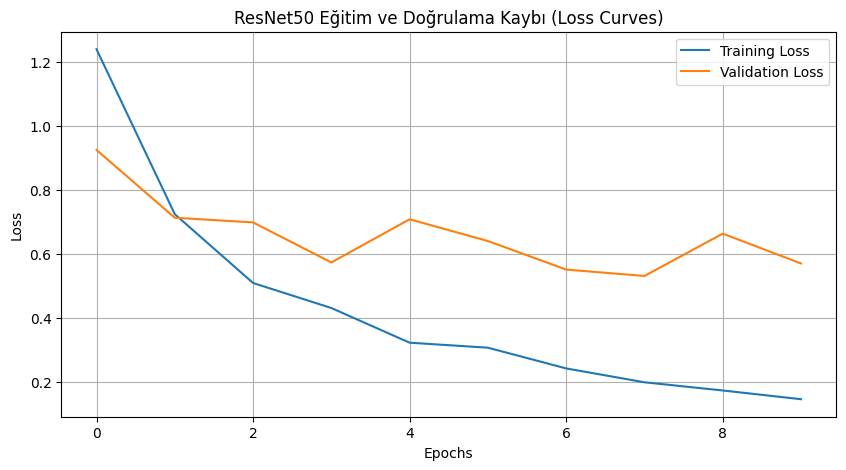

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(rn50_train_losses, label='Training Loss')
plt.plot(rn50_val_losses, label='Validation Loss')
plt.title('ResNet50 Eğitim ve Doğrulama Kaybı (Loss Curves)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

![alt text](../output/figures/resnet50_train_val_loss.png "resnet-50-train-val-loss-image")

--- ResNet50 Test Seti Performans Analizi ---
Test seti üzerinde tahmin yapılıyor...

>>> ResNet50 Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

       akiec       0.77      0.84      0.81        32
         bcc       0.82      0.79      0.80        52
         bkl       0.56      0.89      0.69       110
          df       1.00      0.82      0.90        11
         mel       0.65      0.59      0.62       112
          nv       0.96      0.88      0.92       671
        vasc       0.87      0.93      0.90        14

    accuracy                           0.84      1002
   macro avg       0.80      0.82      0.80      1002
weighted avg       0.87      0.84      0.85      1002



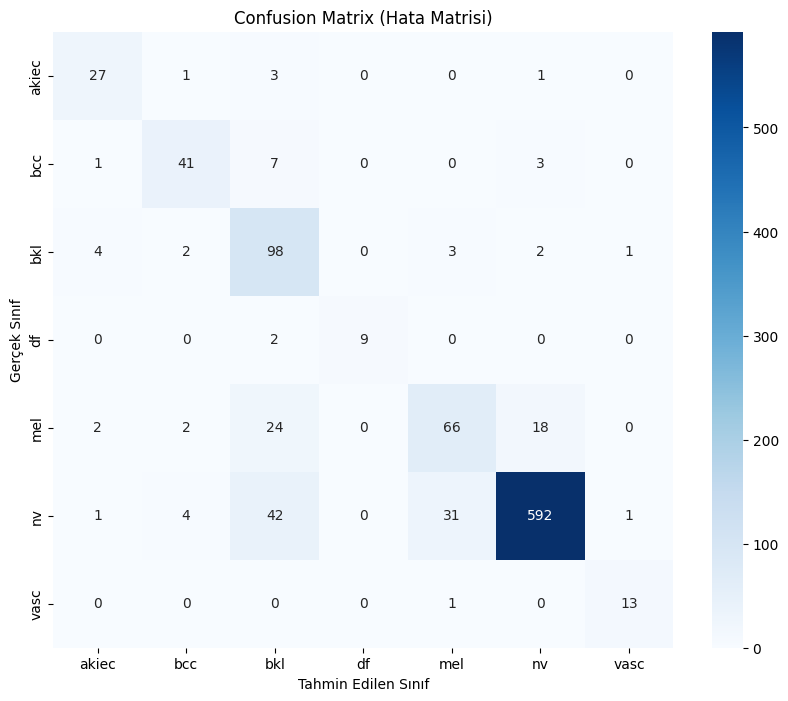

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("--- ResNet50 Test Seti Performans Analizi ---")

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
y_true = []
y_pred = []

print("Test seti üzerinde tahmin yapılıyor...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n>>> ResNet50 Detaylı Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix (Hata Matrisi)')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

In [20]:
print("--- 2. DL Model: Vision Transformer (ViT-B/16) Ablasyon Çalışması Başlıyor ---")

model_vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

num_ftrs = model_vit.heads.head.in_features
model_vit.heads.head = nn.Linear(num_ftrs, len(CLASSES))

model_vit = model_vit.to(device)

# 2.a Ablasyon loss fonksiyonu olarak CrossEntropyLoss kullaniyoruz (Weighted Loss)
criterion = nn.CrossEntropyLoss(weight=class_weights) #class_weights'i yukarida hesapladik

# 2.b Ablasyon optimizer olarak SGD kullaniyoruz (ViT için Learning Rate biraz daha düşük olabilir)
#baseline: optim.SGD(model_vit.parameters(), lr=0.001, momentum=0.9)
optimizer_vit = optim.Adam(model_vit.parameters(), lr=0.0001)

vit_train_losses, vit_val_losses = [], []
num_epochs = 10

for epoch in range(num_epochs):
    print(f'ViT Epoch {epoch+1}/{num_epochs} başlıyor...')

    for phase in ['train', 'val']:
        if phase == 'train': model_vit.train()
        else: model_vit.eval()

        running_loss = 0.0
        running_corrects = 0

        pbar = tqdm(dataloaders[phase], desc=f'{phase} Phase', leave=True)

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer_vit.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_vit(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer_vit.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            current_loss = running_loss / ((pbar.n + 1) * inputs.size(0)) if pbar.n > 0 else loss.item()
            pbar.set_postfix({'loss': f'{current_loss:.4f}'})

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'   {phase.upper()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train': vit_train_losses.append(epoch_loss)
        else: vit_val_losses.append(epoch_loss)

#save
torch.save(model_vit.state_dict(), os.path.join(DRIVE_PROJECT_PATH, 'vit_b16_d2_model.pth'))
print("ViT Modeli Kaydedildi!")

--- 2. DL Model: Vision Transformer (ViT-B/16) Ablasyon Çalışması Başlıyor ---
ViT Epoch 1/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

   TRAIN Loss: 1.5391 Acc: 0.4782


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

   VAL Loss: 1.2144 Acc: 0.5445
ViT Epoch 2/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

   TRAIN Loss: 1.1323 Acc: 0.5891


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

   VAL Loss: 1.3052 Acc: 0.7453
ViT Epoch 3/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

   TRAIN Loss: 0.9870 Acc: 0.6368


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

   VAL Loss: 1.0455 Acc: 0.6044
ViT Epoch 4/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

   TRAIN Loss: 0.8587 Acc: 0.6666


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

   VAL Loss: 0.8890 Acc: 0.7003
ViT Epoch 5/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

   TRAIN Loss: 0.7778 Acc: 0.6767


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

   VAL Loss: 0.7864 Acc: 0.7582
ViT Epoch 6/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

   TRAIN Loss: 0.7105 Acc: 0.7009


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

   VAL Loss: 0.8266 Acc: 0.7283
ViT Epoch 7/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

   TRAIN Loss: 0.6312 Acc: 0.7265


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

   VAL Loss: 0.7279 Acc: 0.7882
ViT Epoch 8/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

   TRAIN Loss: 0.5472 Acc: 0.7473


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

   VAL Loss: 0.7303 Acc: 0.7393
ViT Epoch 9/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

   TRAIN Loss: 0.5585 Acc: 0.7361


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

   VAL Loss: 0.9255 Acc: 0.7323
ViT Epoch 10/10 başlıyor...


train Phase:   0%|          | 0/251 [00:00<?, ?it/s]

   TRAIN Loss: 0.6080 Acc: 0.7374


val Phase:   0%|          | 0/32 [00:00<?, ?it/s]

   VAL Loss: 0.8266 Acc: 0.7243
ViT Modeli Kaydedildi!


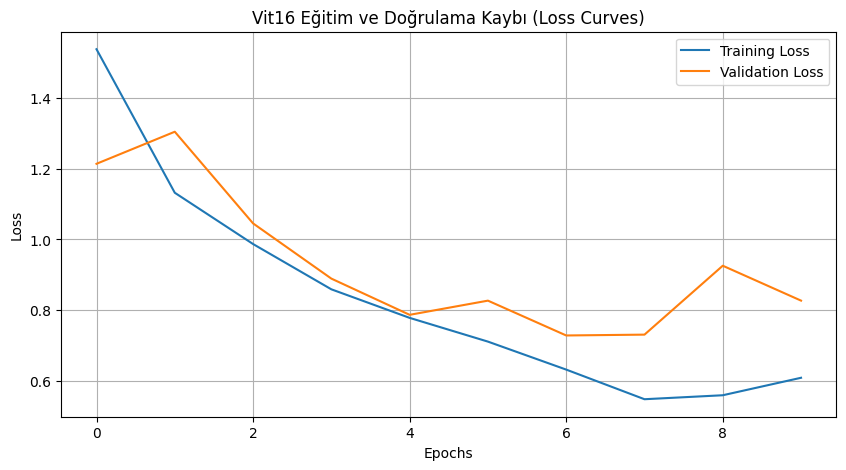

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(vit_train_losses, label='Training Loss')
plt.plot(vit_val_losses, label='Validation Loss')
plt.title('Vit16 Eğitim ve Doğrulama Kaybı (Loss Curves)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

--- Vision Transformer (ViT) Test Seti Performans Analizi ---
ViT ile Test seti üzerinde tahmin yapılıyor...

>>> ViT (Vision Transformer) Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

       akiec       0.32      0.75      0.45        32
         bcc       0.65      0.38      0.48        52
         bkl       0.45      0.78      0.57       110
          df       0.75      0.82      0.78        11
         mel       0.40      0.55      0.47       112
          nv       0.97      0.75      0.85       671
        vasc       0.65      0.93      0.76        14

    accuracy                           0.72      1002
   macro avg       0.60      0.71      0.62      1002
weighted avg       0.80      0.72      0.74      1002



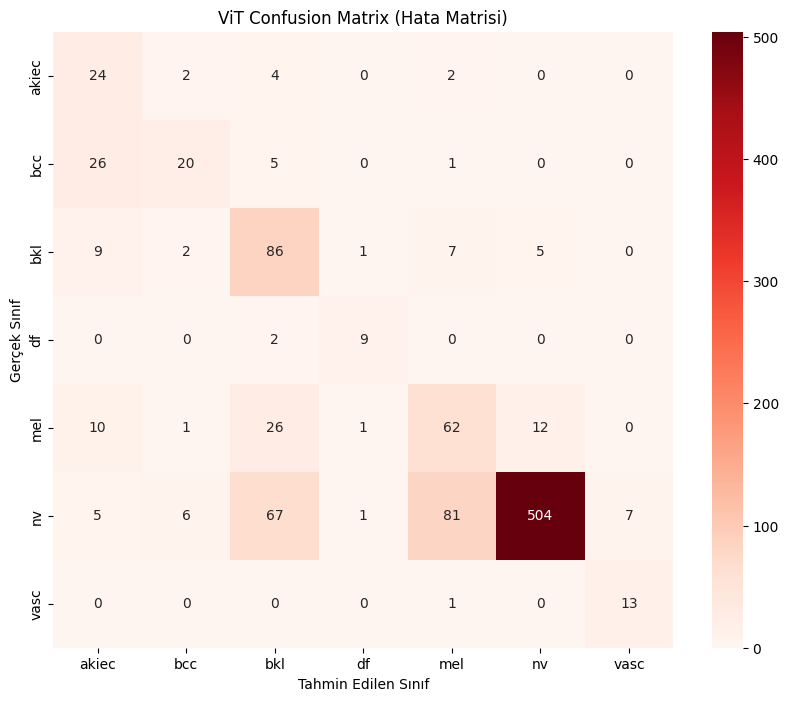

In [22]:
print("--- Vision Transformer (ViT) Test Seti Performans Analizi ---")

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. ViT Modelini Değerlendirme Moduna Al
model_vit.eval()
y_true_vit = []
y_pred_vit = []

# 3. Tahminleri Topla
print("ViT ile Test seti üzerinde tahmin yapılıyor...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # DİKKAT: Burada model_vit kullanıyoruz
        outputs = model_vit(inputs)
        _, preds = torch.max(outputs, 1)

        y_true_vit.extend(labels.cpu().numpy())
        y_pred_vit.extend(preds.cpu().numpy())

# 4. Raporu Yazdır
print("\n>>> ViT (Vision Transformer) Detaylı Sınıflandırma Raporu:")
print(classification_report(y_true_vit, y_pred_vit, target_names=CLASSES))

# 5. Confusion Matrix Çiz
cm_vit = confusion_matrix(y_true_vit, y_pred_vit)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Reds', xticklabels=CLASSES, yticklabels=CLASSES) # Rengi karışmasın diye Kırmızı yaptım
plt.title('ViT Confusion Matrix (Hata Matrisi)')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()